I have used the following methods.

* I used a pretrained <b>Mask R-CNN with ResNeXt-101-32x8d for Feature Pyramid Network</b> from detectron2 [1,2]
* I have modified the official notebook [3]


## Test Set Predictions
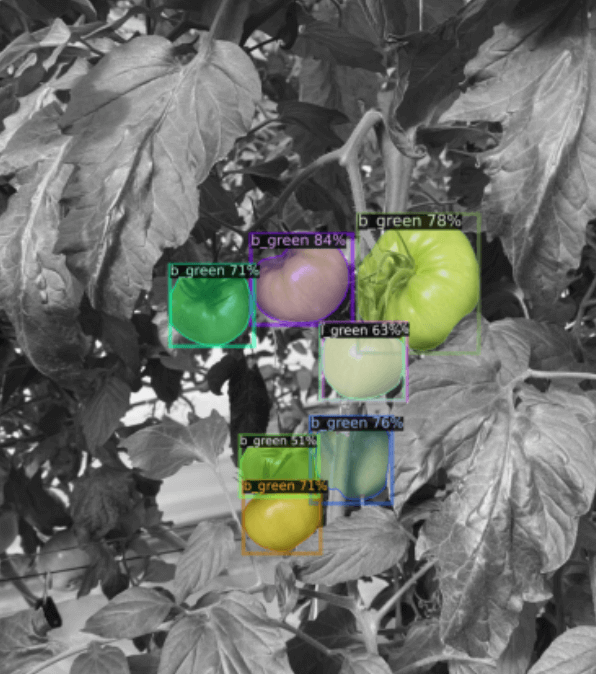
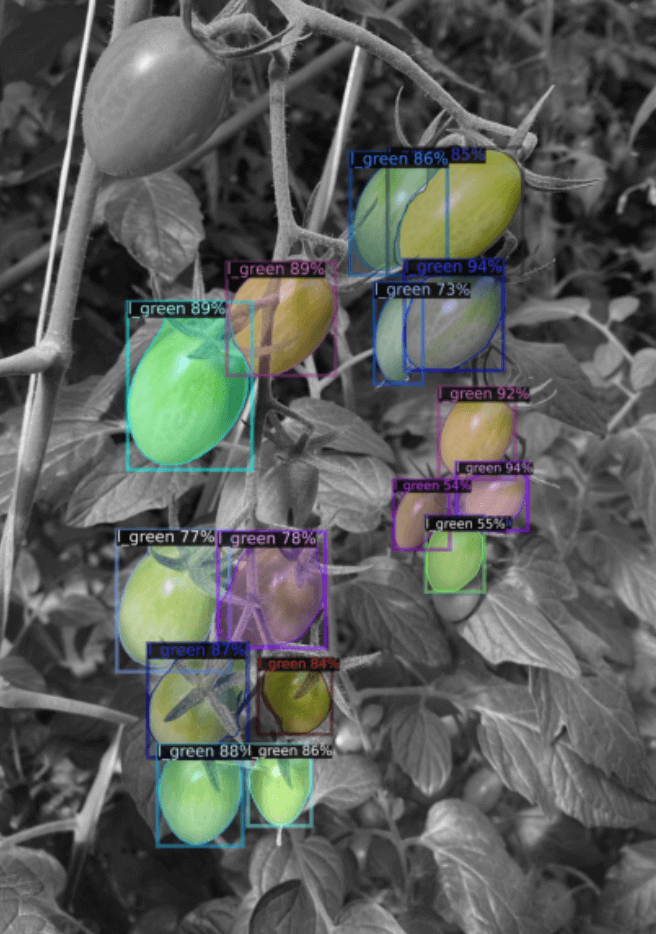


## My Another Projects
* [Fungus Detect w/10CV Custom ConvMixer (F1 Score: 0.85)](https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85)
* [Higgs/Background Process Classification w/CNN,TPU](https://www.kaggle.com/code/banddaniel/higgs-background-process-classification-w-cnn-tpu)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 15
THRESHOLD = 0.5

detectron2 version: 0.6


# <span style="color:#e74c3c;"> Creating </span> Datasets

In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "test"]:
    register_coco_instances(f"laboro_tomato_{d}", {},
                            f"../input/laboro-tomato/annotations/{d}.json",
                            f"../input/laboro-tomato/{d}")

In [4]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("laboro_tomato_train")
train_dataset_dicts = DatasetCatalog.get("laboro_tomato_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[10/19 20:26:18 d2.data.datasets.coco]: Loaded 643 images in COCO format from ../input/laboro-tomato/annotations/train.json


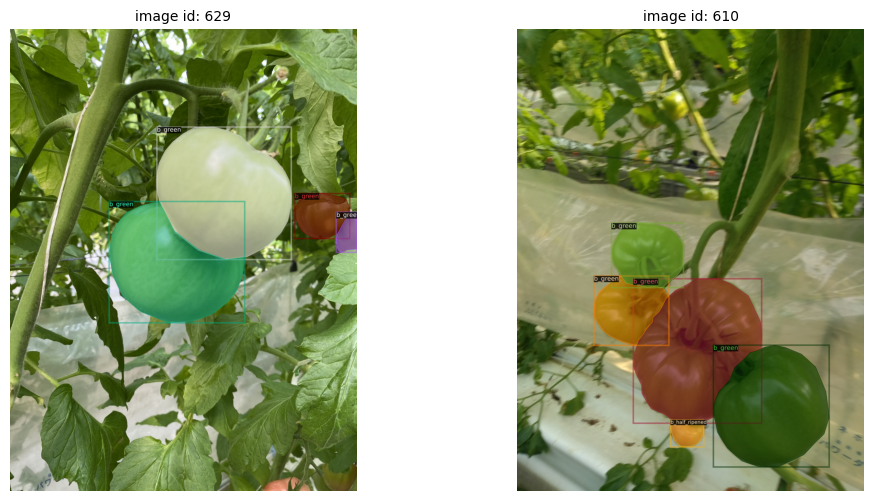

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 65, image_scale = 1)

# <span style="color:#e74c3c;"> Training </span>

In [6]:
from detectron2.engine import DefaultTrainer

EPOCHS = 3000
NUM_CLASSES = 6
BASE_LR = 0.0001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("laboro_tomato_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/19 20:26:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:01, 255MB/s]                           


[10/19 20:26:32 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/19 20:27:04 d2.utils.events]:  eta: 1:00:23  iter: 19  total_loss: 3.765  loss_cls: 1.997  loss_box_reg: 0.6807  loss_mask: 0.6944  loss_rpn_cls: 0.2891  loss_rpn_loc: 0.04693    time: 1.1272  last_time: 0.8266  data_time: 0.0428  last_data_time: 0.0054   lr: 1.9981e-06  max_mem: 5381M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[10/19 20:27:37 d2.utils.events]:  eta: 1:00:31  iter: 39  total_loss: 3.488  loss_cls: 1.952  loss_box_reg: 0.6197  loss_mask: 0.6935  loss_rpn_cls: 0.1119  loss_rpn_loc: 0.03042    time: 1.2051  last_time: 0.8030  data_time: 0.0168  last_data_time: 0.0063   lr: 3.9961e-06  max_mem: 5381M
[10/19 20:28:00 d2.utils.events]:  eta: 1:00:06  iter: 59  total_loss: 3.178  loss_cls: 1.82  loss_box_reg: 0.6152  loss_mask: 0.6892  loss_rpn_cls: 0.05565  loss_rpn_loc: 0.022    time: 1.1840  last_time: 0.9564  data_time: 0.0063  last_data_time: 0.0103   lr: 5.9941e-06  max_mem: 5381M
[10/19 20:28:22 d2.utils.events]:  eta: 0:59:33  iter: 79  total_loss: 3.187  loss_cls: 1.657  loss_box_reg: 0.5879  loss_mask: 0.6828  loss_rpn_cls: 0.1459  loss_rpn_loc: 0.03725    time: 1.1664  last_time: 0.7948  data_time: 0.0061  last_data_time: 0.0062   lr: 7.9921e-06  max_mem: 5381M
[10/19 20:28:43 d2.utils.events]:  eta: 0:58:49  iter: 99  total_loss: 3.044  loss_cls: 1.489  loss_box_reg: 0.7254  loss_mask: 0

In [7]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[10/19 21:23:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;"> Training </span> Results

In [8]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        metric.append(metrics[i][specific_metric])
    return metric

In [9]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = metric(train_metrics, 'loss_mask')
loss_box_reg = metric(train_metrics, 'loss_box_reg')

Text(0.5, 1.0, 'Mask Loss')

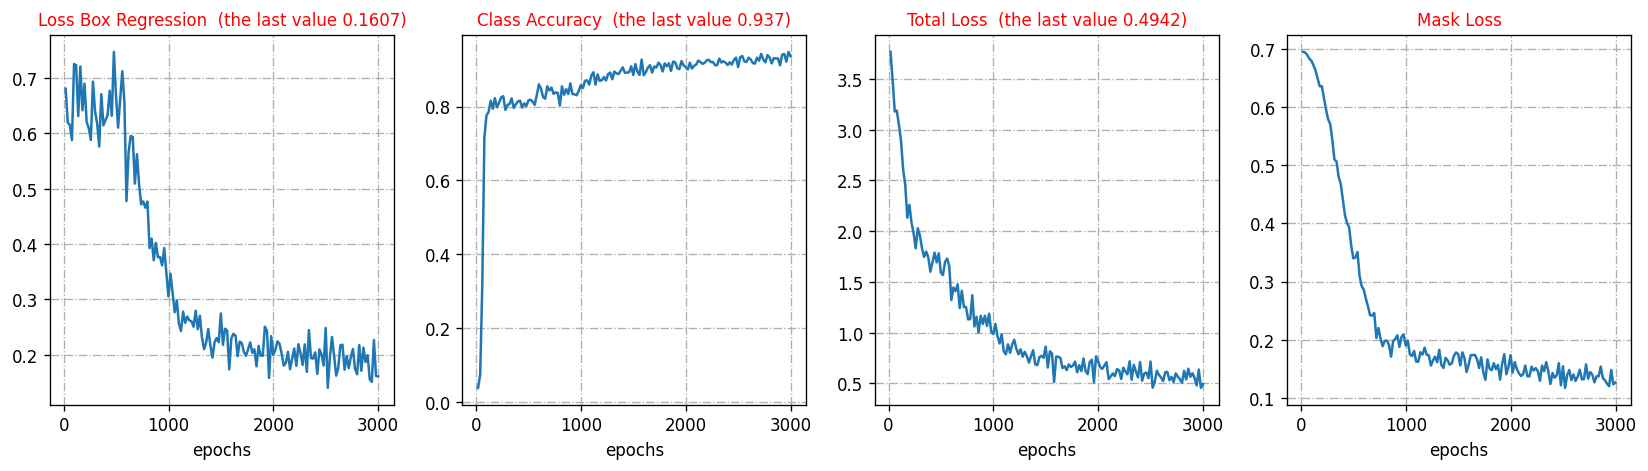

In [10]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, loss_mask)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('Mask Loss', fontsize = 10, color = 'red')

# <span style="color:#e74c3c;"> Test </span> Predictions

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("laboro_tomato_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "laboro_tomato_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[10/19 21:23:05 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[10/19 21:23:06 d2.data.datasets.coco]: Loaded 161 images in COCO format from ../input/laboro-tomato/annotations/test.json
[10/19 21:23:06 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| b_fully_rip.. | 72           | b_half_ripe.. | 116          |  b_green   | 387          |
| l_fully_rip.. | 269          | l_half_ripe.. | 223          |  l_green   | 929          |
|               |              |               |              |            |              |
|     total     | 1996         |               |              |            |              |
[10/19 21:23:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(8

OrderedDict([('bbox',
              {'AP': 60.64691727881936,
               'AP50': 76.53197686805994,
               'AP75': 67.98171558220454,
               'APs': 0.0,
               'APm': 19.670708195862662,
               'APl': 63.77565449540199,
               'AP-b_fully_ripened': 56.4909066735184,
               'AP-b_half_ripened': 58.966972653901564,
               'AP-b_green': 71.32571602742826,
               'AP-l_fully_ripened': 58.567387179566765,
               'AP-l_half_ripened': 56.79686597154958,
               'AP-l_green': 61.733655166951515}),
             ('segm',
              {'AP': 61.94038853624435,
               'AP50': 76.15096163223092,
               'AP75': 69.47828048402818,
               'APs': 0.0,
               'APm': 14.387649302292848,
               'APl': 65.28098997298846,
               'AP-b_fully_ripened': 58.742533628707804,
               'AP-b_half_ripened': 59.27912100300834,
               'AP-b_green': 73.01390366768493,
      

In [12]:
my_dataset_test_metadata = MetadataCatalog.get("laboro_tomato_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("laboro_tomato_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (20,20), dpi = 120)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img[:, :, ::-1], metadata= dataset_metadata, scale=image_scale, instance_mode=ColorMode.IMAGE_BW)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 20)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 20, color = 'red')
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox[:, :, ::-1])
        
    fig.tight_layout()


[10/19 21:27:37 d2.data.datasets.coco]: Loaded 161 images in COCO format from ../input/laboro-tomato/annotations/test.json


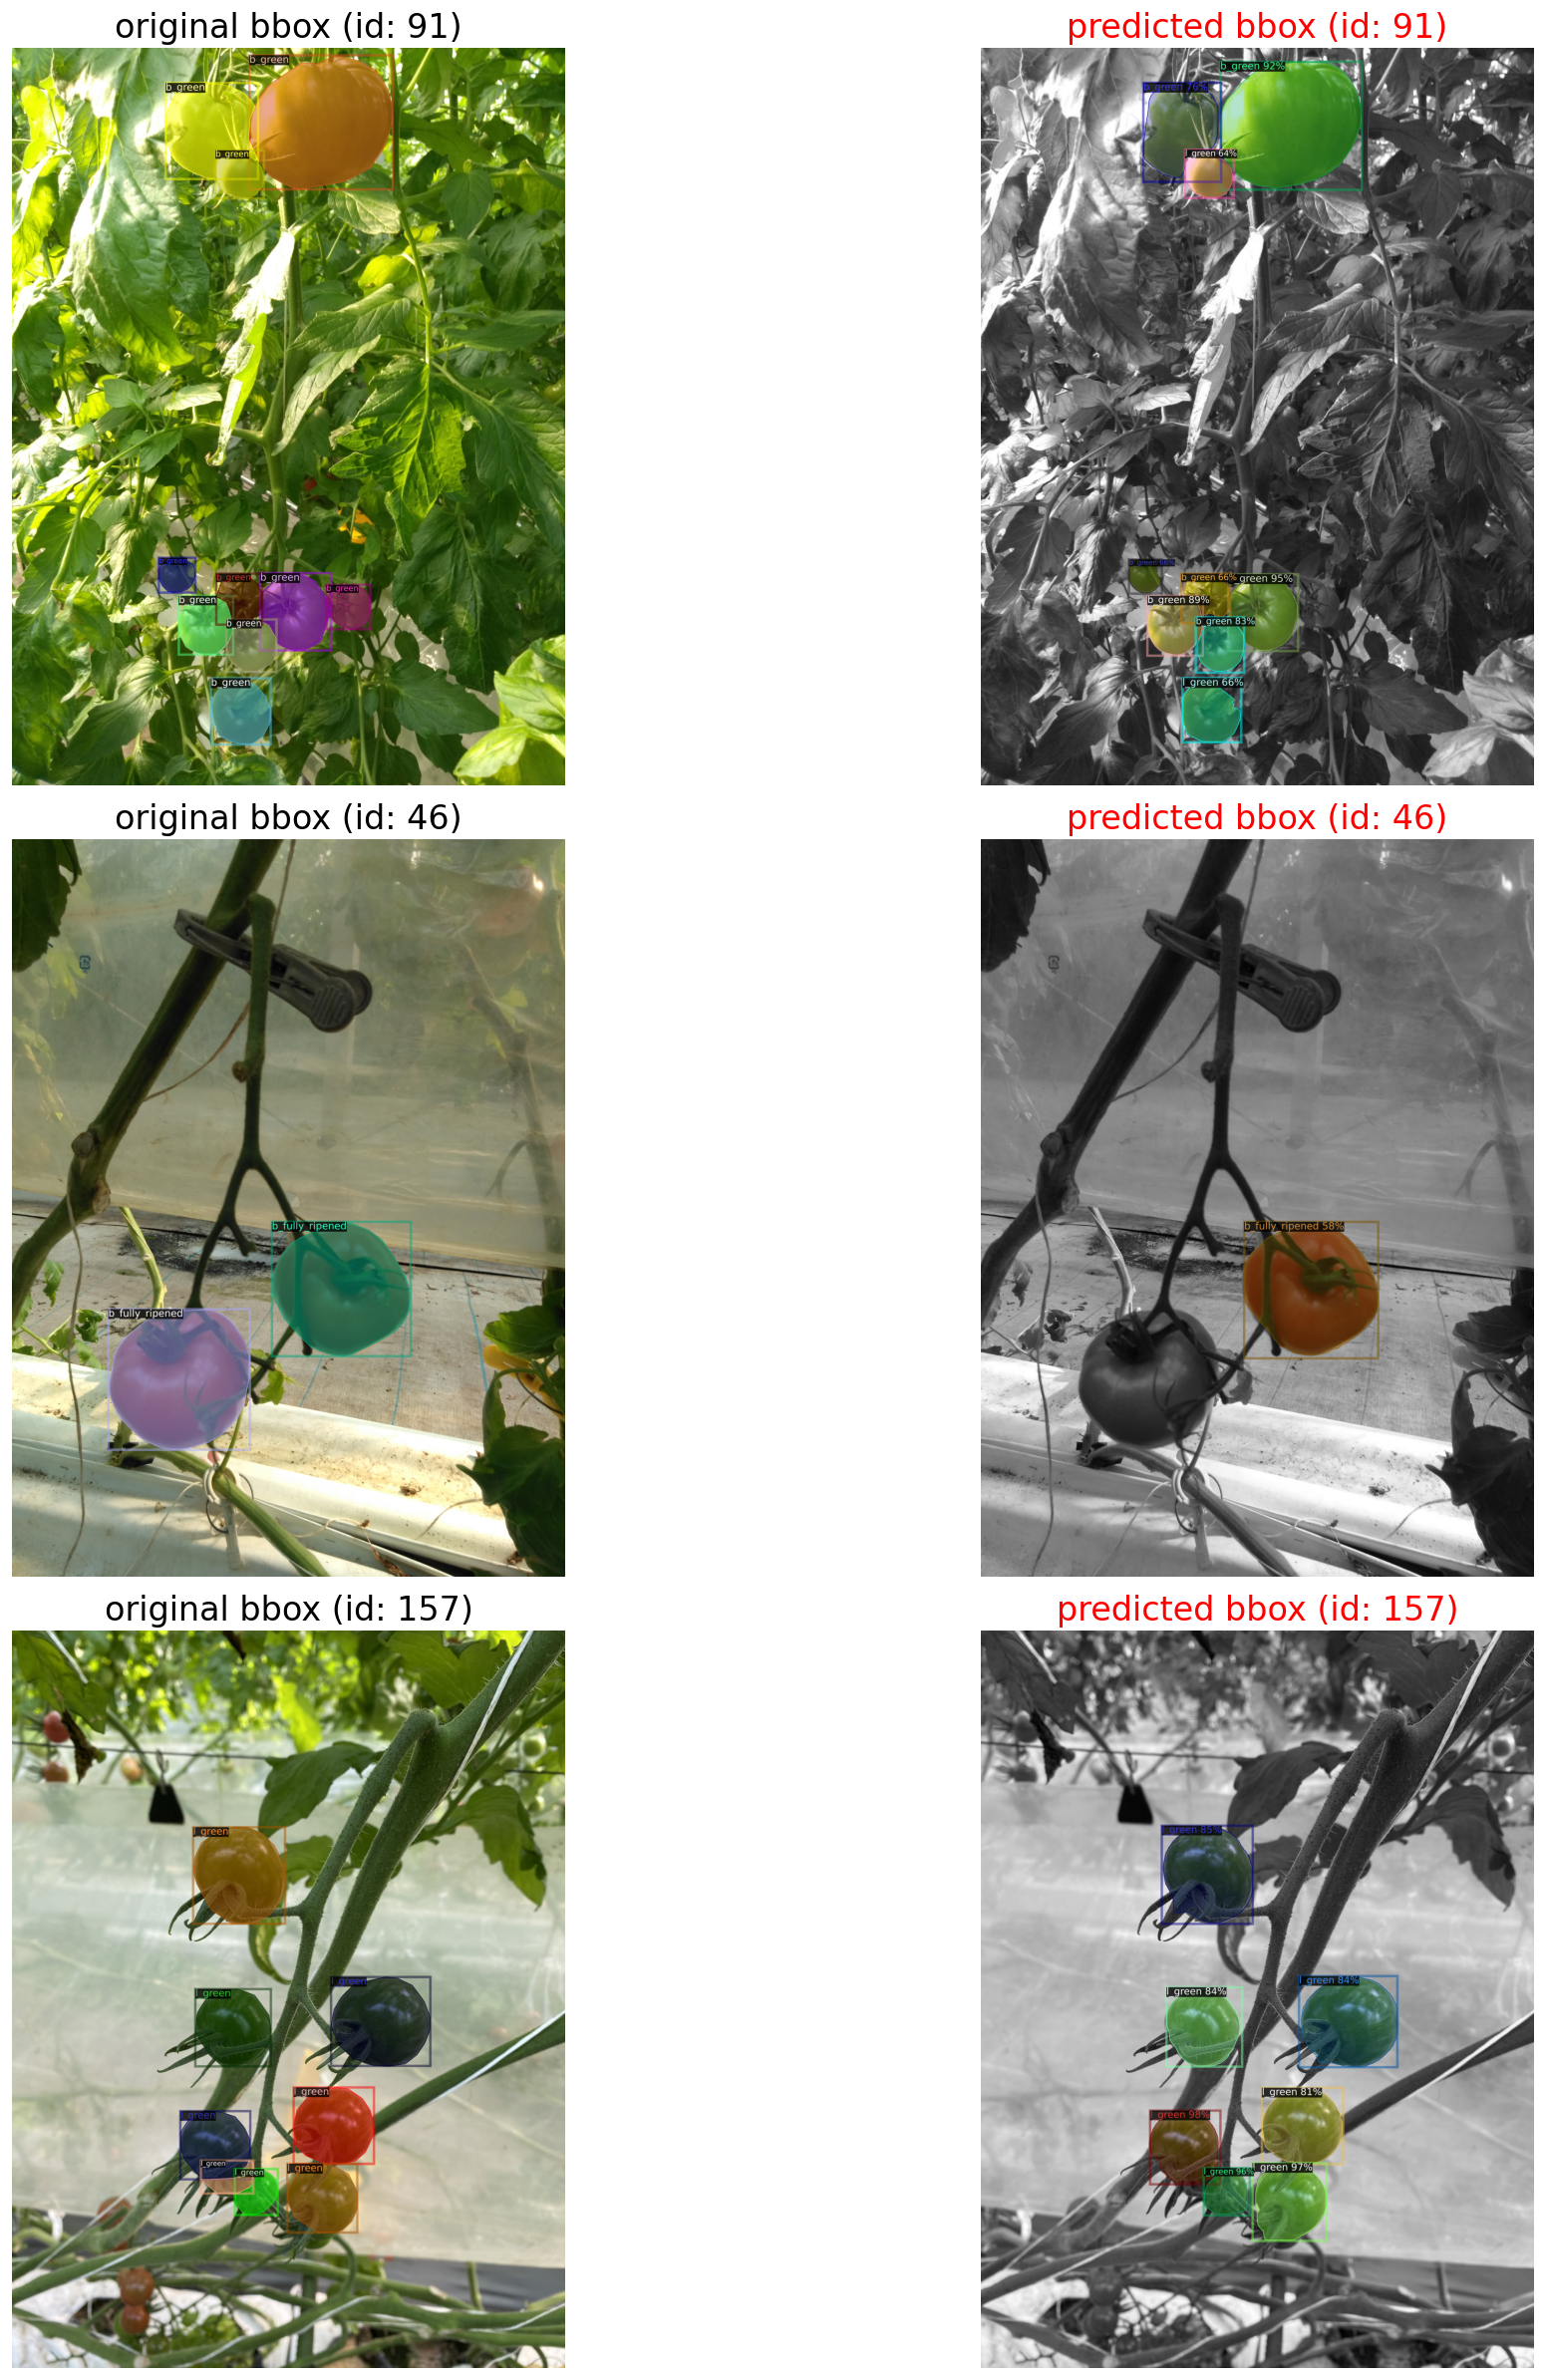

In [13]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 99, image_scale = 2)